In [ ]:
from google.colab import drive
from google.colab import output

In [ ]:
!pip install qiskit
output.clear() #clear the cell output

In [ ]:
from qiskit import *

In [ ]:
#increment operator for a 3-bit state register
def increment_op(circuit):
    qr = circuit.qubits
    
    circuit.mct([qr[0],qr[1],qr[2]],qr[3],None,mode='noancilla')
    circuit.ccx(qr[0],qr[1],qr[2])
    circuit.cx(qr[0],qr[1])

    return circuit

In [ ]:
#decrement operator for a 3-bit state register

def decrement_op(circuit):
    qr = circuit.qubits

    circuit.x(qr)   
    circuit.mct([qr[0],qr[1],qr[2]],qr[3],None,mode='noancilla')
    circuit.ccx(qr[0],qr[1],qr[2])
    circuit.cx(qr[0],qr[1])
    circuit.x(qr)

    return circuit

In [ ]:
def quantum_walk_step(circuit):
    #increment operator circuit
    qr_incr = QuantumRegister(4)
    increment_circ = QuantumCircuit(qr_incr, name='increment')
    increment_op(increment_circ)
    increment_inst = increment_circ.to_instruction()

    #decrement operator circuit
    qr_decr = QuantumRegister(4)
    decrement_circ = QuantumCircuit(qr_decr, name='decrement')
    decrement_op(decrement_circ)sns.set(font_scale=5)  
    decrement_inst = decrement_circ.to_instruction()

    circuit.h(qr[0]) #coin
    circuit.append(increment_inst, qr[0:4]) # adder
    circuit.append(decrement_inst, qr[0:4]) # decrementer
    
    return circuit   

In [ ]:
def quantum_walk(steps, circuit):
    for i in range(0, steps):
        random_walk_step(circuit)
    return circuit

In [ ]:
#construct the circuit
qr = QuantumRegister(4)
cr = ClassicalRegister(3)
circuit = QuantumCircuit(qr, cr)

quantum_walk_step(circuit)

circuit.draw()

┌───┐┌────────────┐┌────────────┐
q0_0: ┤ H ├┤0           ├┤0           ├
      └───┘│            ││            │
q0_1: ─────┤1           ├┤1           ├
           │  increment ││  decrement │
q0_2: ─────┤2           ├┤2           ├
           │            ││            │
q0_3: ─────┤3           ├┤3           ├
           └────────────┘└────────────┘
c0: 3/═════════════════════════════════

In [ ]:
# the decomposed version
decomposed = circuit.decompose()
decomposed.draw()

┌─────────┐               ┌───┐               ┌───┐
q0_0: ┤ U2(0,π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├
      └─────────┘  │    │  ┌─┴─┐├───┤  │    │  ┌─┴─┐├───┤
q0_1: ─────────────■────■──┤ X ├┤ X ├──■────■──┤ X ├┤ X ├
                   │  ┌─┴─┐├───┤└───┘  │  ┌─┴─┐├───┤└───┘
q0_2: ─────────────■──┤ X ├┤ X ├───────■──┤ X ├┤ X ├─────
                 ┌─┴─┐├───┤└───┘     ┌─┴─┐├───┤└───┘     
q0_3: ───────────┤ X ├┤ X ├──────────┤ X ├┤ X ├──────────
                 └───┘└───┘          └───┘└───┘          
c0: 3/═══════════════════════════════════════════════════

In [ ]:
#construct the circuit
qr = QuantumRegister(4)
cr = ClassicalRegister(3)
circuit = QuantumCircuit(qr, cr)

# perform a walk of n-steps and measure at the end
STEPS = 5

for i in range(0, STEPS):
  quantum_walk_step(circuit)
circuit.measure(qr[1:4], cr)

#simulate the circuit
simulator = Aer.get_backend('qasm_simulator')
result_simulation = execute(circuit, simulator).result()

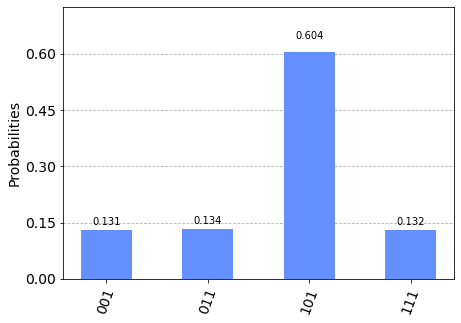

In [ ]:

from qiskit.tools.visualization import plot_histogram, plot_circuit_layout
plot_histogram(result_simulation.get_counts(circuit))

In [ ]:
from qiskit import IBMQ
IBMQ.save_account()

In [ ]:
IBMQ.load_account()

/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:
provider = IBMQ.get_provider('ibm-q')

In [ ]:
qcomp = provider.get_backend('ibmq_16_melbourne')

In [ ]:
job = execute(circuit, backend=qcomp)

In [ ]:
from qiskit.tools.monitor import job_monitor

In [ ]:
job_monitor(job)

Job Status: job has successfully run


In [ ]:
result = job.result()

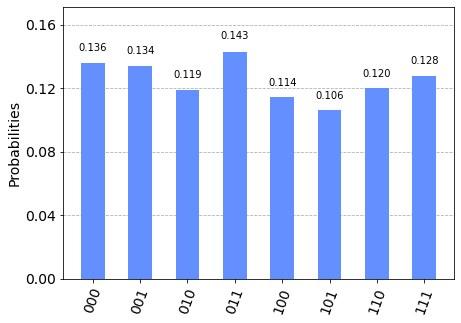

In [ ]:
plot_histogram(result.get_counts(circuit))

In [ ]:
#------------------------------
# RESULTS CHART
#------------------------------
import pandas as pd

rsim = result_simulation.get_counts()
real = result.get_counts()

SHOTS = 1024
labels = ['000', '001', '010', '011', '100', '101', '110', '111']

rsim_dict = {}
real_dict = {}
for l in labels:
  rsim_dict[l] = rsim.get(l) / SHOTS if l in rsim.keys() else 0
  real_dict[l] = real.get(l) / SHOTS if l in real.keys() else 0

rsim_df = pd.DataFrame.from_dict(rsim_dict.items())
real_df = pd.DataFrame.from_dict(real_dict.items())

# assign different labels
rsim_df.columns = ['label', 'prob_simulation']
real_df.columns = ['label', 'prob_real']

# join simul and real result on labels
results = pd.merge(rsim_df, real_df, on='label')
results

,label,prob_simulation,prob_real
0,000,0.000000,0.135742
1,001,0.130859,0.133789
2,010,0.000000,0.119141
3,011,0.133789,0.142578
4,100,0.000000,0.114258
5,101,0.603516,0.106445
6,110,0.000000,0.120117
7,111,0.131836,0.127930


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


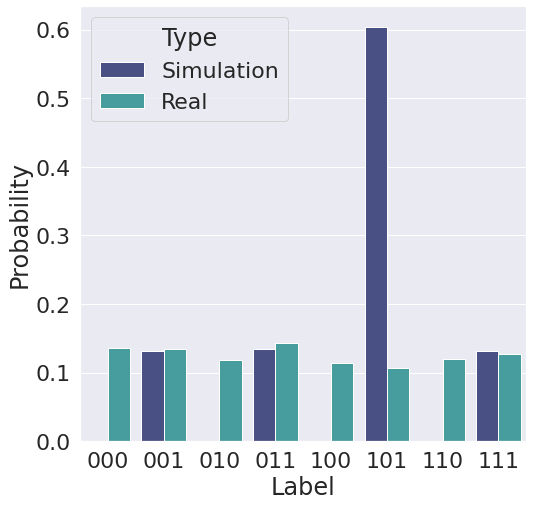

In [ ]:
#------------------------------
# COMPARISON REAL AND SIM
#------------------------------
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font_scale=2)  
plt.figure(figsize=(8, 8)) # width and height in inches

df = pd.DataFrame({
    'Label': list(results.label),
    'Simulation': list(results.prob_simulation),
    'Real': list(results.prob_real)
})

tidy = df.melt(id_vars='Label').rename(columns=str.title)
tidy.columns = ['Label', 'Type', 'Probability']
ax = sns.barplot(x='Label', y='Probability', hue='Type', data=tidy, palette='mako')
plt.savefig('results_CQW.eps', format='eps')